In [1]:
from faker import Faker
from faker.providers import BaseProvider, internet 
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings('ignore')

# 绘图初始化
%matplotlib inline
sns.set(style="ticks")

In [23]:
###导入数据集
df=pd.read_csv('支付成功率最终v2.csv')
# 更改列名: treatment代表是否上策略；class代表是否是实验组，1表示实验组，0表示对照组
df = df.rename(columns={"新策略是否上线": "treatment", "日期（月日）": "dt","是否是实验组": "category",'支付成功率': 'payment_success_rate'})
df=df[df['dt']<1208]
df.head(10)

,treatment,dt,拉起支付次数,payment_success_rate,category
3,1,1207,926051,76.879288,0
4,1,1206,906574,77.521532,0
5,1,1205,906444,77.570909,0
6,1,1204,952567,77.874682,0
7,1,1203,959195,76.387761,0
8,1,1202,931874,77.038128,0
9,1,1201,974929,76.535552,0
10,0,1130,996654,76.655137,0
11,0,1129,873409,76.928274,0
12,0,1128,860485,77.629923,0


In [24]:
# 假设你的DataFrame名为df，日期列名为'dt'
df['dt'] = df['dt'].apply(lambda x: '2023' + '-' + str(x)[0:2] + '-' + str(x)[2:])

# 然后使用pd.to_datetime转换为日期类型
df['dt'] = pd.to_datetime(df['dt'])
df.head(10)

,treatment,dt,拉起支付次数,payment_success_rate,category
3,1,2023-12-07,926051,76.879288,0
4,1,2023-12-06,906574,77.521532,0
5,1,2023-12-05,906444,77.570909,0
6,1,2023-12-04,952567,77.874682,0
7,1,2023-12-03,959195,76.387761,0
8,1,2023-12-02,931874,77.038128,0
9,1,2023-12-01,974929,76.535552,0
10,0,2023-11-30,996654,76.655137,0
11,0,2023-11-29,873409,76.928274,0
12,0,2023-11-28,860485,77.629923,0


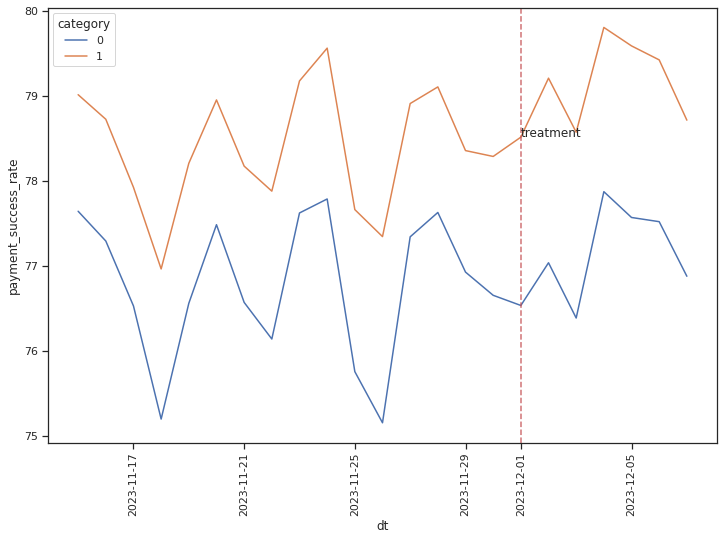

In [25]:
# 计算文字的y坐标
y_text = df.query('dt == "2023-12-01" and category==1')['payment_success_rate'].values[0]
# 绘图查看干预前后趋势
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x="dt", y="payment_success_rate", hue="category", data=df)
ax.axvline(pd.Timestamp('2023-12-01'), color='r', linestyle="--", alpha=0.8)
plt.text(pd.Timestamp('2023-12-01'), y_text, 'treatment')
# 将 x 轴标签旋转为垂直方向
plt.xticks(rotation='vertical')
plt.show()

In [26]:
###平行趋势检验
df_pre = df[df['dt'] < "2023-12-01"]
# 根据 dt 列的值为 DataFrame 添加新列 new_treatment，用于检验平行趋势
df_pre['new_treatment'] = df_pre['dt'].apply(lambda x: 0 if x < pd.Timestamp('2023-11-23') else 1)
df_pre.head(10)

,treatment,dt,拉起支付次数,payment_success_rate,category,new_treatment
10,0,2023-11-30,996654,76.655137,0,1
11,0,2023-11-29,873409,76.928274,0,1
12,0,2023-11-28,860485,77.629923,0,1
13,0,2023-11-27,830121,77.343228,0,1
14,0,2023-11-26,884783,75.155040,0,1
15,0,2023-11-25,928806,75.756953,0,1
16,0,2023-11-24,908901,77.788628,0,1
17,0,2023-11-23,911600,77.623938,0,1
18,0,2023-11-22,878865,76.140793,0,0
19,0,2023-11-21,803394,76.571690,0,0


In [27]:
##检验平行趋势，即检验回归中交互项的系数是否显著
df_pre['new_treatment*category'] = df_pre['new_treatment']*df_pre['category'] # 交互项

# 执行线性回归
est_pre = smf.ols(formula='payment_success_rate ~ new_treatment + category + new_treatment*category', data=df_pre).fit()
print(est_pre.summary())

                             OLS Regression Results                             
Dep. Variable:     payment_success_rate   R-squared:                       0.541
Model:                              OLS   Adj. R-squared:                  0.492
Method:                   Least Squares   F-statistic:                     10.99
Date:                  Mon, 11 Dec 2023   Prob (F-statistic):           6.06e-05
Time:                          20:56:34   Log-Likelihood:                -36.501
No. Observations:                    32   AIC:                             81.00
Df Residuals:                        28   BIC:                             86.86
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

In [28]:
###计算策略效应
df['treatment*category'] = df['treatment']*df['category'] # 交互项

# 执行线性回归
est = smf.ols(formula='payment_success_rate ~ treatment + category + treatment*category', data=df).fit()
print(est.summary())

                             OLS Regression Results                             
Dep. Variable:     payment_success_rate   R-squared:                       0.629
Model:                              OLS   Adj. R-squared:                  0.602
Method:                   Least Squares   F-statistic:                     23.73
Date:                  Mon, 11 Dec 2023   Prob (F-statistic):           3.84e-09
Time:                          20:56:42   Log-Likelihood:                -48.701
No. Observations:                    46   AIC:                             105.4
Df Residuals:                        42   BIC:                             112.7
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

In [29]:
df_cal = df.groupby(['category', 'treatment'])['payment_success_rate'].mean()
df_cal

category  treatment
0         0            76.769187
          1            77.115407
1         0            78.391812
          1            79.119908
Name: payment_success_rate, dtype: float64

In [30]:
effect = (df_cal.loc[1, 1] - df_cal.loc[1, 0]) - \
        (df_cal.loc[0, 1] - df_cal.loc[0, 0])
print(effect)

0.3818761119642744


###带时间效应的DID

In [31]:
# 将 dt 列转换为月日格式的字符串
df['dt_str'] = df['dt'].dt.strftime('%m%d')

# 将 dt_str 列转换为哑变量
dummies = pd.get_dummies(df['dt_str'], prefix='')

# 将哑变量添加到 DataFrame
df_new = pd.concat([df, dummies], axis=1)

df_new.head(10)

,treatment,dt,拉起支付次数,payment_success_rate,category,treatment*category,dt_str,_1115,_1116,_1117,...,_1128,_1129,_1130,_1201,_1202,_1203,_1204,_1205,_1206,_1207
3,1,2023-12-07,926051,76.879288,0,0,1207,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,2023-12-06,906574,77.521532,0,0,1206,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,2023-12-05,906444,77.570909,0,0,1205,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,1,2023-12-04,952567,77.874682,0,0,1204,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1,2023-12-03,959195,76.387761,0,0,1203,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,1,2023-12-02,931874,77.038128,0,0,1202,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,1,2023-12-01,974929,76.535552,0,0,1201,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10,0,2023-11-30,996654,76.655137,0,0,1130,0,0,0,...,0,0,1,0,0,0,0,0,0,0
11,0,2023-11-29,873409,76.928274,0,0,1129,0,0,0,...,0,1,0,0,0,0,0,0,0,0
12,0,2023-11-28,860485,77.629923,0,0,1128,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [32]:
###平行趋势检验
df_pre_new = df_new[df_new['dt'] < "2023-12-01"]
# 根据 dt 列的值为 DataFrame 添加新列 new_treatment，用于检验平行趋势
df_pre_new['new_treatment'] = df_pre_new['dt'].apply(lambda x: 0 if x < pd.Timestamp('2023-11-23') else 1)
df_pre_new.head(10)

,treatment,dt,拉起支付次数,payment_success_rate,category,treatment*category,dt_str,_1115,_1116,_1117,...,_1129,_1130,_1201,_1202,_1203,_1204,_1205,_1206,_1207,new_treatment
10,0,2023-11-30,996654,76.655137,0,0,1130,0,0,0,...,0,1,0,0,0,0,0,0,0,1
11,0,2023-11-29,873409,76.928274,0,0,1129,0,0,0,...,1,0,0,0,0,0,0,0,0,1
12,0,2023-11-28,860485,77.629923,0,0,1128,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,0,2023-11-27,830121,77.343228,0,0,1127,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14,0,2023-11-26,884783,75.155040,0,0,1126,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15,0,2023-11-25,928806,75.756953,0,0,1125,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16,0,2023-11-24,908901,77.788628,0,0,1124,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17,0,2023-11-23,911600,77.623938,0,0,1123,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18,0,2023-11-22,878865,76.140793,0,0,1122,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,2023-11-21,803394,76.571690,0,0,1121,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
##检验平行趋势，即检验回归中交互项的系数是否显著
df_pre_new['new_treatment*category'] = df_pre_new['new_treatment']*df_pre_new['category'] # 交互项


# 获取所有哑变量列名
dummy_columns = [col for col in df_pre_new.columns if col not in ['payment_success_rate', 'category','treatment','dt','拉起支付次数','treatment*category','dt_str','new_treatment']]

# 创建公式字符串
formula = 'payment_success_rate ~ ' + ' + '.join(dummy_columns) + ' + category+new_treatment:category'

# 执行线性回归
est_pre = smf.ols(formula=formula, data=df_pre_new).fit()
print(est_pre.summary())

                             OLS Regression Results                             
Dep. Variable:     payment_success_rate   R-squared:                       0.992
Model:                              OLS   Adj. R-squared:                  0.983
Method:                   Least Squares   F-statistic:                     104.4
Date:                  Mon, 11 Dec 2023   Prob (F-statistic):           8.11e-12
Time:                          20:57:13   Log-Likelihood:                 28.641
No. Observations:                    32   AIC:                            -21.28
Df Residuals:                        14   BIC:                             5.101
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

In [16]:
formula

'payment_success_rate ~ _1115 + _1116 + _1117 + _1118 + _1119 + _1120 + _1121 + _1122 + _1123 + _1124 + _1125 + _1126 + _1127 + _1128 + _1129 + _1130 + _1201 + _1202 + _1203 + _1204 + _1205 + _1206 + _1207 + _1208 + _1209 + _1210 + new_treatment*category + category'

In [34]:
# 获取df_new的所有哑变量列名
dummy_columns_all = [col for col in df_new.columns if col not in ['payment_success_rate', 'category','treatment','dt','拉起支付次数','treatment*category','dt_str','new_treatment']]

# 创建公式
formula_all = 'payment_success_rate ~ ' + ' + '.join(dummy_columns_all) + ' + category+ treatment:category'

# 执行线性回归
est_pre = smf.ols(formula=formula_all, data=df_new).fit()
print(est_pre.summary())

                             OLS Regression Results                             
Dep. Variable:     payment_success_rate   R-squared:                       0.993
Model:                              OLS   Adj. R-squared:                  0.986
Method:                   Least Squares   F-statistic:                     129.8
Date:                  Mon, 11 Dec 2023   Prob (F-statistic):           6.97e-18
Time:                          20:57:22   Log-Likelihood:                 43.634
No. Observations:                    46   AIC:                            -37.27
Df Residuals:                        21   BIC:                             8.449
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

In [ ]:
formula_all